In [ ]:
!pip install tensorflow numpy matplotlib seaborn scikit-learn


Mounted at /content/drive
Found 4122 images belonging to 4 classes.
Found 1029 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training Custom CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1710s 13s/step - accuracy: 0.4680 - loss: 1.9983 - val_accuracy: 0.4908 - val_loss: 1.0674
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.5661 - loss: 0.9154 - val_accuracy: 0.4101 - val_loss: 1.0981
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.7049 - loss: 0.6765 - val_accuracy: 0.4325 - val_loss: 1.0942
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.8157 - loss: 0.4441 - val_accuracy: 0.6045 - val_loss: 0.9060
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9092 - loss: 0.2486 - val_accuracy: 0.6336 - val_loss: 0.8540
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 22s 167ms/step - accuracy: 0.9391 - loss: 0.1559 - val_accuracy: 0.6307 - val_loss: 0.9067
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 151ms/step - accuracy: 0.9602 - loss: 0.1140 - val_accuracy: 0.6569 - val_loss: 0.9449
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - accuracy: 0.9729 - loss: 0

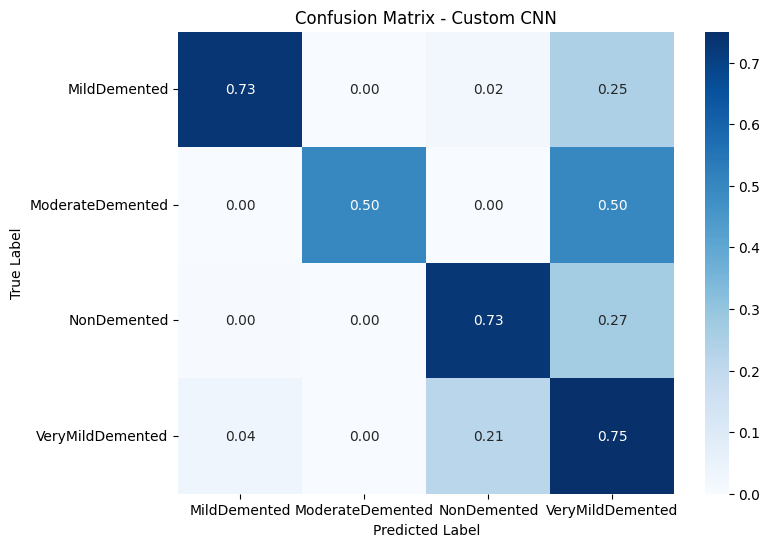

ResNet50 Accuracy: 0.4587


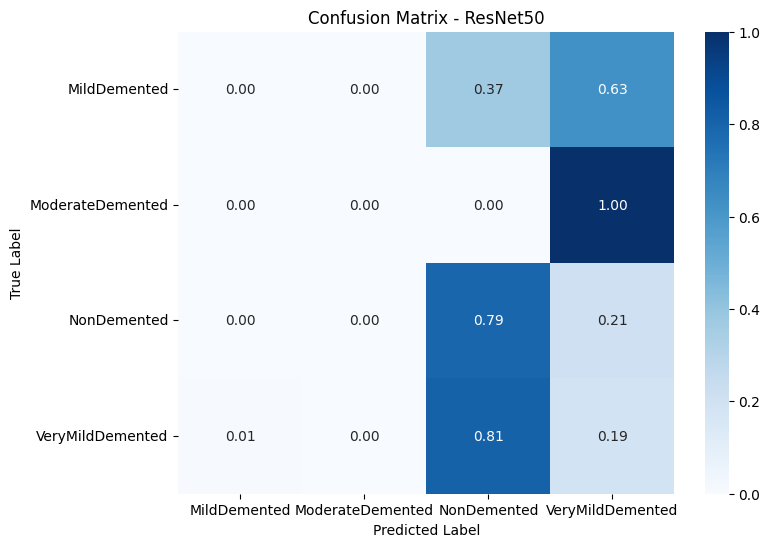

VGG16 Accuracy: 0.6764


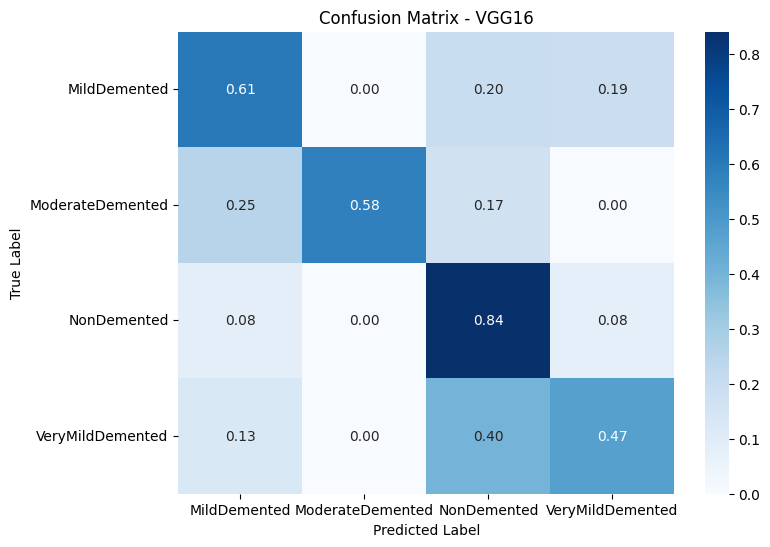

CNN + VGG Accuracy: 0.7493


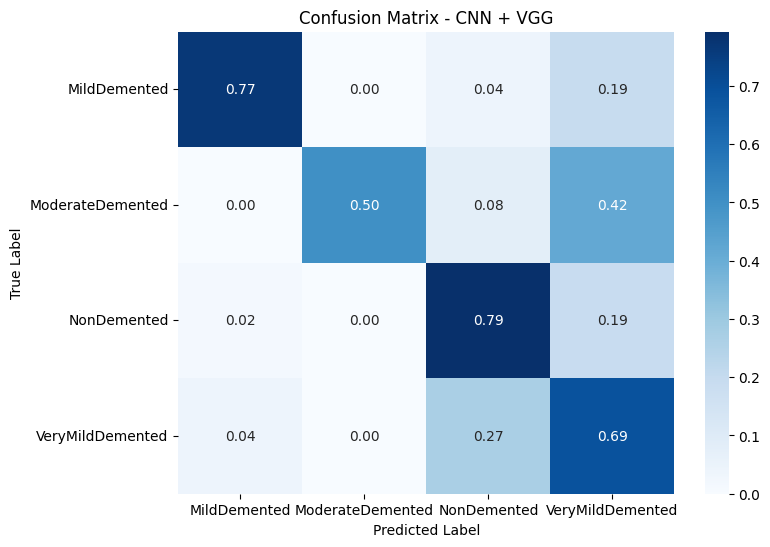

CNN + ResNet Accuracy: 0.7191


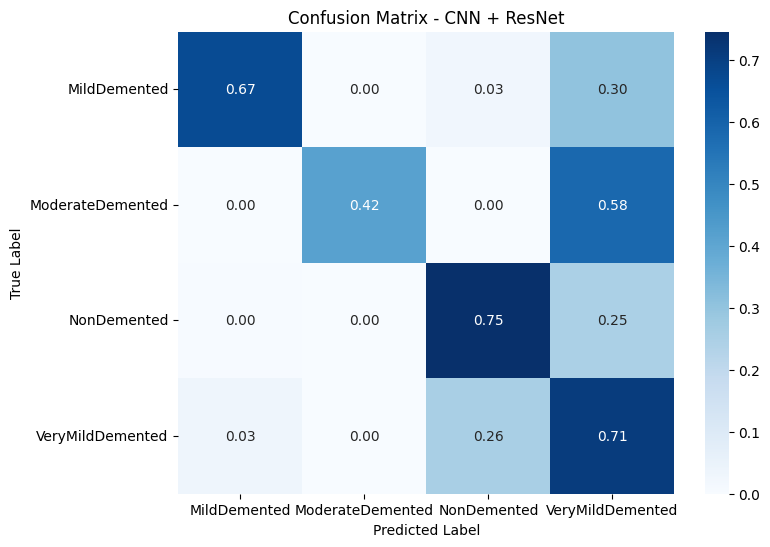

ResNet + VGG Accuracy: 0.6599


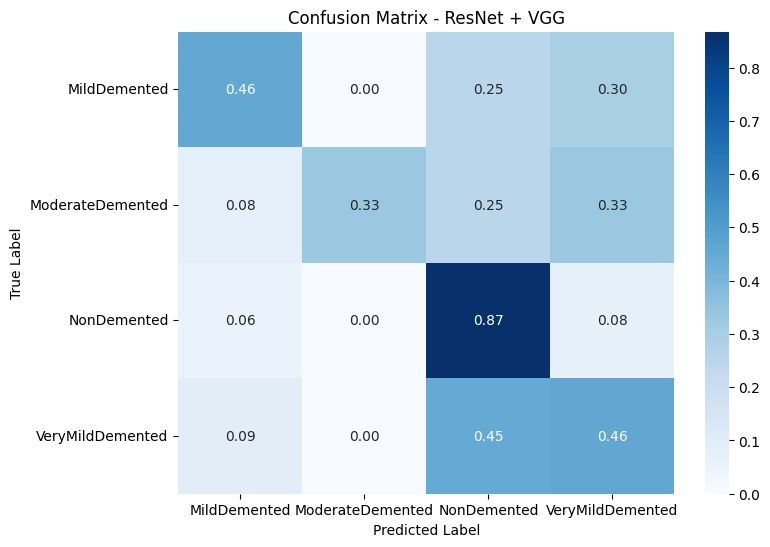

All Three Accuracy: 0.7211


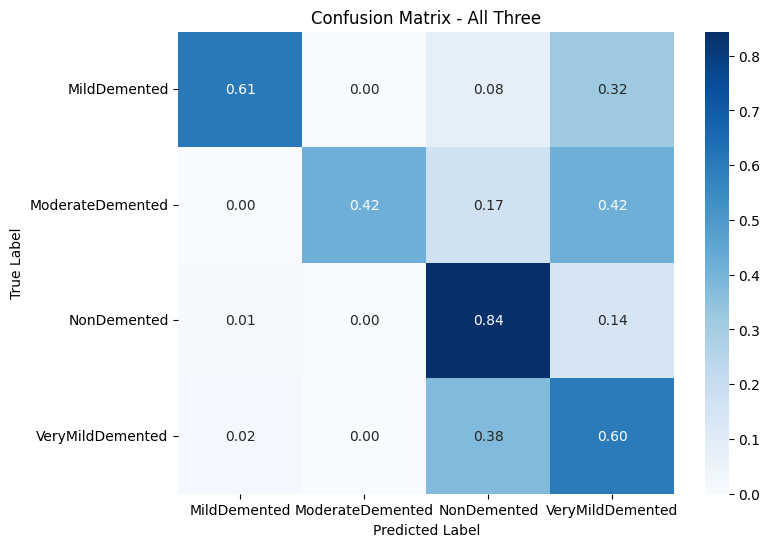

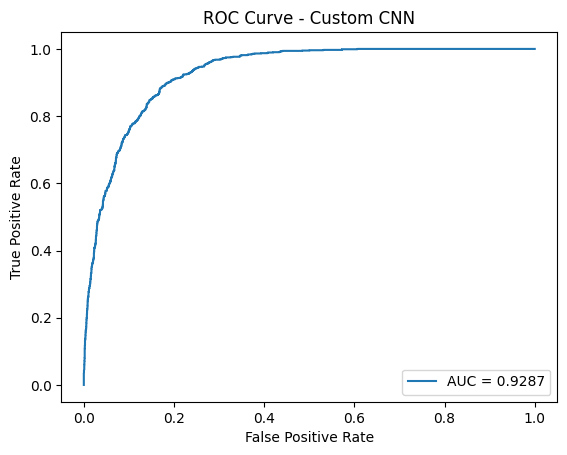

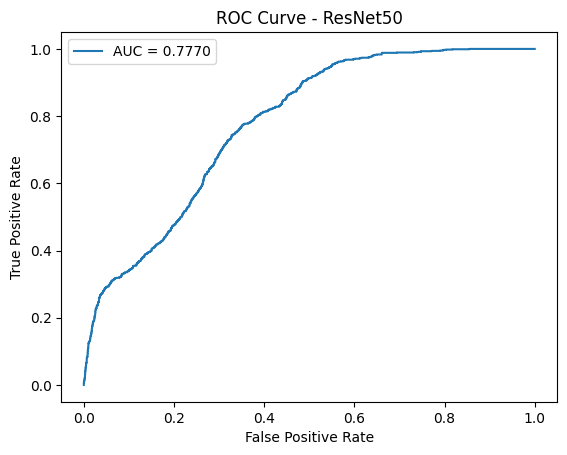

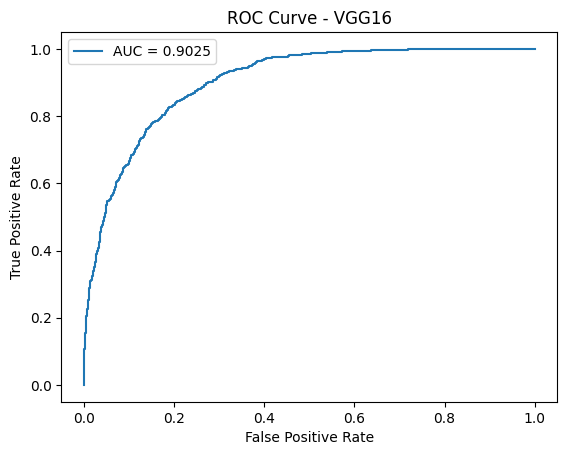

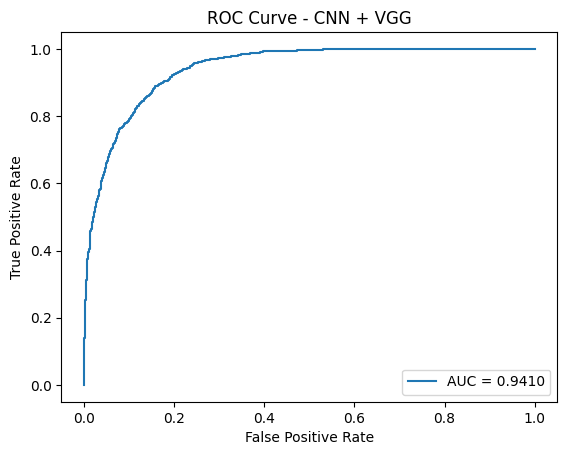

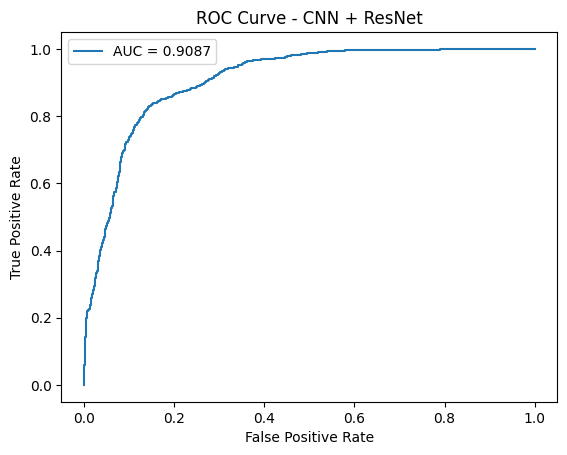

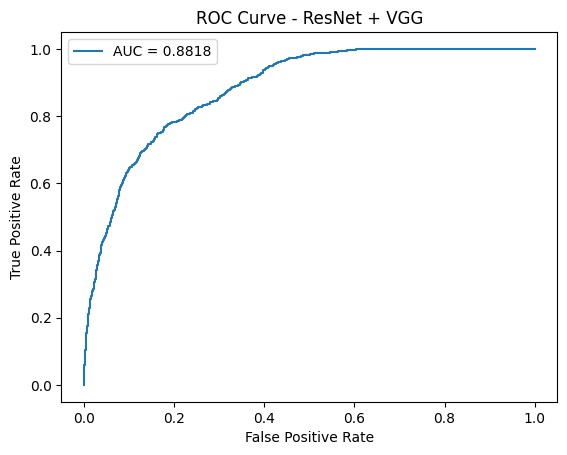

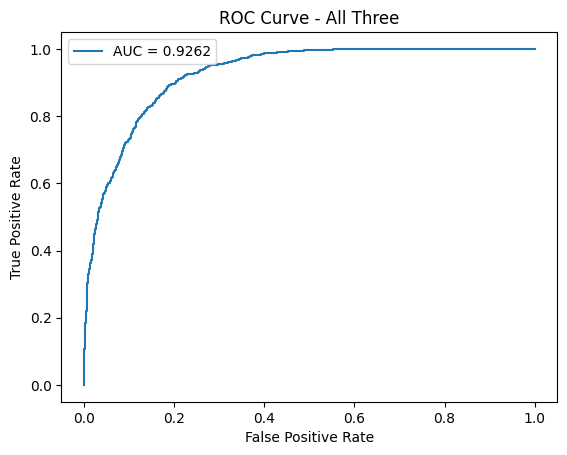

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Dataset Path (Ensure your dataset is in Google Drive or uploaded manually)
DATASET_PATH = "/content/drive/MyDrive/Alzheimer_Dataset/train"  # Change this if needed
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

# Load Dataset
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_data = datagen.flow_from_directory(DATASET_PATH, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', subset='training', shuffle=True)
val_data = datagen.flow_from_directory(DATASET_PATH, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', subset='validation', shuffle=False)

# Define Custom CNN Model
def build_custom_cnn():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(train_data.num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Load Pretrained ResNet50 Model
def build_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
    for layer in base_model.layers: layer.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dense(train_data.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Load Pretrained VGG16 Model
def build_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
    for layer in base_model.layers: layer.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dense(train_data.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train Models
custom_cnn = build_custom_cnn()
resnet50 = build_resnet50()
vgg16 = build_vgg16()

print("Training Custom CNN...")
custom_cnn.fit(train_data, validation_data=val_data, epochs=EPOCHS)

print("Training ResNet50...")
resnet50.fit(train_data, validation_data=val_data, epochs=EPOCHS)

print("Training VGG16...")
vgg16.fit(train_data, validation_data=val_data, epochs=EPOCHS)

# Get Model Predictions
def get_predictions(model, data):
    return model.predict(data)

cnn_preds = get_predictions(custom_cnn, val_data)
resnet_preds = get_predictions(resnet50, val_data)
vgg_preds = get_predictions(vgg16, val_data)

# Ensemble Methods
def ensemble_average(preds_list):
    return np.mean(preds_list, axis=0)

def ensemble_weighted(preds_list, weights):
    weighted_preds = np.zeros_like(preds_list[0])
    for i in range(len(preds_list)):
        weighted_preds += preds_list[i] * weights[i]
    return weighted_preds / np.sum(weights)

# Different Ensemble Combinations
ensemble_cnn_vgg = ensemble_average([cnn_preds, vgg_preds])
ensemble_cnn_resnet = ensemble_average([cnn_preds, resnet_preds])
ensemble_resnet_vgg = ensemble_average([resnet_preds, vgg_preds])
ensemble_all = ensemble_weighted([cnn_preds, resnet_preds, vgg_preds], weights=[0.3, 0.4, 0.3])

# Evaluate Ensembles
def evaluate_ensemble(preds, true_labels):
    acc = np.mean(np.argmax(preds, axis=1) == np.argmax(true_labels, axis=1))
    return acc

y_true = val_data.classes  # True labels
y_true_one_hot = np.zeros((len(y_true), train_data.num_classes))
for i, label in enumerate(y_true):
    y_true_one_hot[i, label] = 1

# Generate Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=train_data.class_indices.keys(), yticklabels=train_data.class_indices.keys())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

print("\nModel Performance:")
for name, preds in zip(["Custom CNN", "ResNet50", "VGG16", "CNN + VGG", "CNN + ResNet", "ResNet + VGG", "All Three"],
                        [cnn_preds, resnet_preds, vgg_preds, ensemble_cnn_vgg, ensemble_cnn_resnet, ensemble_resnet_vgg, ensemble_all]):
    print(f"{name} Accuracy: {evaluate_ensemble(preds, y_true_one_hot):.4f}")
    plot_confusion_matrix(y_true, preds, f"Confusion Matrix - {name}")

# ROC Curve and AUC
def plot_roc_curve(y_true, y_pred, title):
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_pred.ravel())
    auc_score = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.show()

for name, preds in zip(["Custom CNN", "ResNet50", "VGG16", "CNN + VGG", "CNN + ResNet", "ResNet + VGG", "All Three"],
                        [cnn_preds, resnet_preds, vgg_preds, ensemble_cnn_vgg, ensemble_cnn_resnet, ensemble_resnet_vgg, ensemble_all]):
    plot_roc_curve(y_true_one_hot, preds, f"ROC Curve - {name}")


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Dataset Path (Ensure your dataset is in Google Drive or uploaded manually)
DATASET_PATH = "/content/drive/MyDrive/Alzheimer_Dataset/train"  # Change this if needed
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

# Load Dataset
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_data = datagen.flow_from_directory(DATASET_PATH, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', subset='training', shuffle=True)
val_data = datagen.flow_from_directory(DATASET_PATH, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', subset='validation', shuffle=False)

# Define Custom CNN Model
def build_custom_cnn():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(train_data.num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Load Pretrained ResNet50 Model
def build_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
    for layer in base_model.layers: layer.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dense(train_data.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Load Pretrained VGG16 Model
def build_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
    for layer in base_model.layers: layer.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dense(train_data.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train Models
custom_cnn = build_custom_cnn()
resnet50 = build_resnet50()
vgg16 = build_vgg16()

print("Training Custom CNN...")
custom_cnn.fit(train_data, validation_data=val_data, epochs=EPOCHS)

print("Training ResNet50...")
resnet50.fit(train_data, validation_data=val_data, epochs=EPOCHS)

print("Training VGG16...")
vgg16.fit(train_data, validation_data=val_data, epochs=EPOCHS)

# Save Best Model
models = {"Custom_CNN": custom_cnn, "ResNet50": resnet50, "VGG16": vgg16}
accuracies = {}

for name, model in models.items():
    _, acc = model.evaluate(val_data)
    accuracies[name] = acc

best_model_name = max(accuracies, key=accuracies.get)
print(f"Best Model: {best_model_name} with Accuracy: {accuracies[best_model_name]:.4f}")
models[best_model_name].save(f"/content/drive/MyDrive/Best_Model_{best_model_name}.h5")

# Get Model Predictions
def get_predictions(model, data):
    return model.predict(data)

cnn_preds = get_predictions(custom_cnn, val_data)
resnet_preds = get_predictions(resnet50, val_data)
vgg_preds = get_predictions(vgg16, val_data)

# Ensemble Methods
def ensemble_average(preds_list):
    return np.mean(preds_list, axis=0)

def ensemble_weighted(preds_list, weights):
    weighted_preds = np.zeros_like(preds_list[0])
    for i in range(len(preds_list)):
        weighted_preds += preds_list[i] * weights[i]
    return weighted_preds / np.sum(weights)

# Different Ensemble Combinations
ensemble_cnn_vgg = ensemble_average([cnn_preds, vgg_preds])
ensemble_cnn_resnet = ensemble_average([cnn_preds, resnet_preds])
ensemble_resnet_vgg = ensemble_average([resnet_preds, vgg_preds])
ensemble_all = ensemble_weighted([cnn_preds, resnet_preds, vgg_preds], weights=[0.3, 0.4, 0.3])

# Save Best Ensemble Model
ensemble_models = {"CNN_VGG": ensemble_cnn_vgg, "CNN_ResNet": ensemble_cnn_resnet, "ResNet_VGG": ensemble_resnet_vgg, "All": ensemble_all}
ensemble_accuracies = {}

for name, preds in ensemble_models.items():
    y_true = val_data.classes
    y_pred = np.argmax(preds, axis=1)
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    ensemble_accuracies[name] = accuracy

best_ensemble_name = max(ensemble_accuracies, key=ensemble_accuracies.get)
print(f"Best Ensemble Model: {best_ensemble_name} with Accuracy: {ensemble_accuracies[best_ensemble_name]:.4f}")
np.save(f"/content/drive/MyDrive/Best_Ensemble_{best_ensemble_name}.npy", ensemble_models[best_ensemble_name])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 4122 images belonging to 4 classes.
Found 1029 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Custom CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 32s 204ms/step - accuracy: 0.4673 - loss: 1.7886 - val_accuracy: 0.3936 - val_loss: 1.1558
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - accuracy: 0.6938 - loss: 0.7158 - val_accuracy: 0.4227 - val_loss: 1.1620
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.8407 - loss: 0.4100 - val_accuracy: 0.6054 - val_loss: 0.9200
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 0.9192 - loss: 0.2278 - val_accuracy: 0.6181 - val_loss: 0.9135
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.9482 - loss: 0.1491 - val_accuracy: 0.6919 - val_loss: 0.8776
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.9594 - loss: 0.1155 - val_accuracy: 0.7240 - val_loss: 0.7881
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 0.9744 - loss: 0.0780 - val_accuracy: 0.7094 - val_loss: 0.9401
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.9783 - loss: 0

Best Model: Custom_CNN with Accuracy: 0.7687
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 242ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step
Best Ensemble Model: CNN_VGG with Accuracy: 0.7716
